# **Data Augmentation To Address Overfitting In Flower Classification CNN**

In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc

In below image, 4 new training samples are generated from original sample using different transformations

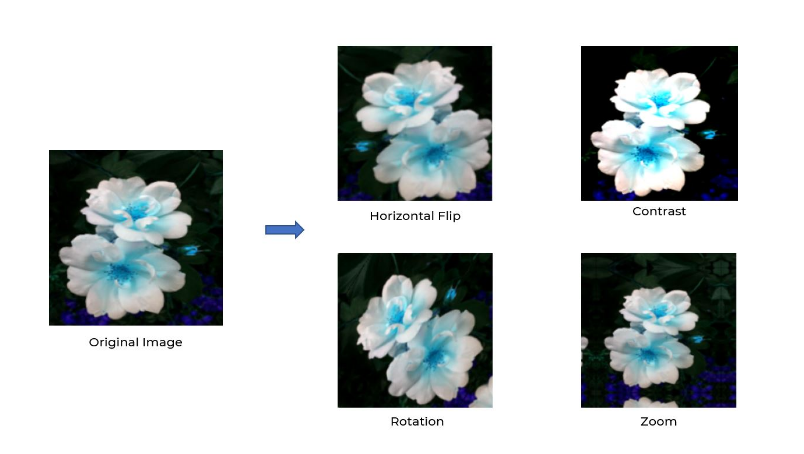

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data = tf.keras.utils.get_file(fname="flower_photos", origin=dataset_url, cache_dir='/content', untar=True)

In [4]:
data

'/content/datasets/flower_photos'

In [5]:
import pathlib
data_dir = pathlib.Path(data)
data_dir

PosixPath('/content/datasets/flower_photos')

In [7]:
list(data_dir.glob("*/*.jpg"))[:5]

[PosixPath('/content/datasets/flower_photos/sunflowers/4932144003_cbffc89bf0.jpg'),
 PosixPath('/content/datasets/flower_photos/sunflowers/18097401209_910a46fae1_n.jpg'),
 PosixPath('/content/datasets/flower_photos/sunflowers/14925397351_c7f209d804_n.jpg'),
 PosixPath('/content/datasets/flower_photos/sunflowers/8014735546_3db46bb1fe_n.jpg'),
 PosixPath('/content/datasets/flower_photos/sunflowers/8543642705_b841b0e5f6.jpg')]

In [10]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(f"Total no of images: {image_count}")

Total no of images: 3670


In [18]:
daisies = list(data_dir.glob("daisy/*.jpg"))
daisies[:5]

[PosixPath('/content/datasets/flower_photos/daisy/5885826924_38fdc6bcaa_n.jpg'),
 PosixPath('/content/datasets/flower_photos/daisy/8446495985_f72d851482.jpg'),
 PosixPath('/content/datasets/flower_photos/daisy/13826249325_f61cb15f86_n.jpg'),
 PosixPath('/content/datasets/flower_photos/daisy/21626652132_97e1318bb8_m.jpg'),
 PosixPath('/content/datasets/flower_photos/daisy/3356112863_75da8bca2c_m.jpg')]

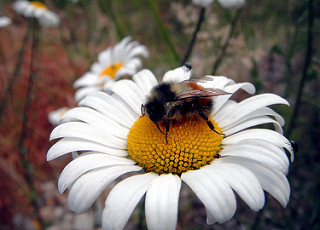

In [19]:
PIL.Image.open(daisies[0])

In [20]:
roses = list(data_dir.glob("roses/*.jpg"))
roses[:5]

[PosixPath('/content/datasets/flower_photos/roses/4413509121_a62879598a.jpg'),
 PosixPath('/content/datasets/flower_photos/roses/9216323421_f737c1d50e.jpg'),
 PosixPath('/content/datasets/flower_photos/roses/16316557109_7fc55c1cbc_m.jpg'),
 PosixPath('/content/datasets/flower_photos/roses/9216321995_83df405ea9.jpg'),
 PosixPath('/content/datasets/flower_photos/roses/1562198683_8cd8cb5876_n.jpg')]

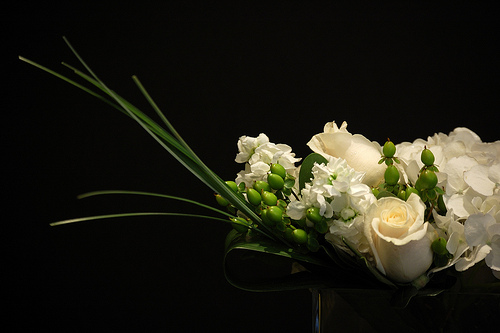

In [21]:
PIL.Image.open(roses[0])

In [6]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [7]:
flowers_label_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [24]:
img = cv2.imread(str(flowers_images_dict["roses"][0]))
img.shape

(333, 500, 3)

In [25]:
new_img = cv2.resize(img, (180, 180))
new_img.shape

(180, 180, 3)

In [8]:
X = []
Y = []
for flower, images in flowers_images_dict.items():
  for x in images:
    img = cv2.imread(str(x))
    resized_img = cv2.resize(img, (180, 180))
    X.append(resized_img)
    Y.append(flowers_label_dict[flower])



In [9]:
X = np.array(X)
Y = np.array(Y)

In [10]:
X.shape, Y.shape

((3670, 180, 180, 3), (3670,))

array([[[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [4, 4, 4],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       ...,

       [[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [3, 3, 3]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [3, 3, 3]]], dtype=uint8)
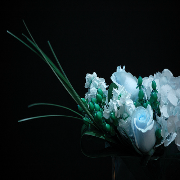

In [29]:
X[0]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [17]:
num_classes = len(flowers_label_dict.keys())

In [19]:
model = Sequential(
    [
        layers.Conv2D(filters=128, kernel_size=3, padding="same", input_shape=X_train_scaled[0].shape, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="sigmoid")
    ]
)

In [20]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
model.fit(X_train_scaled, Y_train, epochs=10)

Epoch 1/10
92/92 [==============================] - 15s 86ms/step - loss: 1.2618 - accuracy: 0.4632
Epoch 2/10
92/92 [==============================] - 6s 65ms/step - loss: 1.0040 - accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 6s 67ms/step - loss: 0.8495 - accuracy: 0.6757
Epoch 4/10
92/92 [==============================] - 6s 65ms/step - loss: 0.6658 - accuracy: 0.7449
Epoch 5/10
92/92 [==============================] - 6s 68ms/step - loss: 0.4614 - accuracy: 0.8317
Epoch 6/10
92/92 [==============================] - 6s 66ms/step - loss: 0.3013 - accuracy: 0.8924
Epoch 7/10
92/92 [==============================] - 6s 68ms/step - loss: 0.1556 - accuracy: 0.9520
Epoch 8/10
92/92 [==============================] - 6s 67ms/step - loss: 0.1352 - accuracy: 0.9527
Epoch 9/10
92/92 [==============================] - 6s 68ms/step - loss: 0.0808 - accuracy: 0.9789
Epoch 10/10
92/92 [==============================] - 6s 67ms/step - loss: 0.0851 - accuracy: 0.9779


In [22]:
model.evaluate(X_test_scaled, Y_test)

23/23 [==============================] - 2s 61ms/step - loss: 2.1142 - accuracy: 0.6362


[2.1142148971557617, 0.636239767074585]

**Here we see that while train accuracy is very high (98%), the test accuracy is significantly low (63%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting**

In [23]:
predictions = model.predict(X_test_scaled)
predictions

23/23 [==============================] - 1s 19ms/step


array([[8.18090796e-01, 1.40456453e-01, 3.64766902e-06, 3.82323116e-01,
        9.99998569e-01],
       [7.92726517e-01, 1.13356391e-05, 9.52193320e-01, 9.99999881e-01,
        1.01206757e-01],
       [4.43494171e-02, 9.61990178e-01, 4.67163861e-01, 6.74285329e-05,
        9.96447146e-01],
       ...,
       [4.86662466e-05, 9.99997854e-01, 1.14296556e-01, 1.33074978e-02,
        5.05115569e-01],
       [6.04739673e-02, 2.54520830e-02, 9.99997377e-01, 1.79759879e-02,
        1.47516415e-01],
       [5.27952425e-02, 5.83743870e-01, 9.73822474e-01, 5.51793993e-01,
        4.71596092e-01]], dtype=float32)

In [24]:
Y_test[1]

3

In [25]:
label_flowers_dict = {v: i for i, v in flowers_label_dict.items()}

In [26]:
print(f"Actual value of 10th element: {label_flowers_dict[Y_test[10]]}")

Actual value of 10th element: roses


In [27]:
print(f"Predicted value of 10th element: {label_flowers_dict[np.argmax(predictions[10])]}")

Predicted value of 10th element: daisy


# **Improve Test Accuracy Using Data Augmentation**

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X_train_scaled[0].shape),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

# Original image

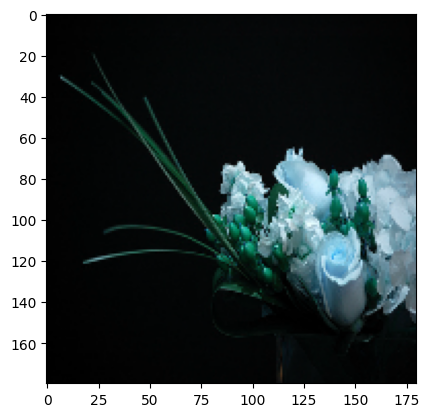

In [29]:
plt.imshow(X[0])

# Augmented image

In [30]:
augmented_images = data_augmentation(X)
augmented_images.shape

TensorShape([3670, 180, 180, 3])

In [31]:
X.shape

(3670, 180, 180, 3)

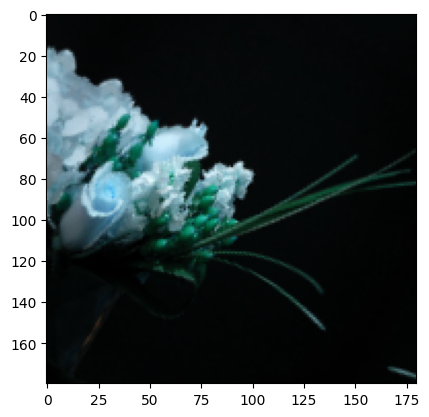

In [32]:
plt.imshow(augmented_images[0].numpy().astype("uint8"))

# Train the model using data augmentation and a drop out layer

In [33]:
new_model = Sequential(
    [
        data_augmentation,
        layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="sigmoid")
    ]
)

In [34]:
new_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [35]:
new_model.fit(X_train_scaled, Y_train, epochs=10)

Epoch 1/10
92/92 [==============================] - 8s 36ms/step - loss: 1.2922 - accuracy: 0.4486
Epoch 2/10
92/92 [==============================] - 3s 28ms/step - loss: 1.0360 - accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 3s 28ms/step - loss: 0.9283 - accuracy: 0.6325
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.8859 - accuracy: 0.6550
Epoch 5/10
92/92 [==============================] - 3s 31ms/step - loss: 0.8156 - accuracy: 0.6843
Epoch 6/10
92/92 [==============================] - 3s 29ms/step - loss: 0.7790 - accuracy: 0.7047
Epoch 7/10
92/92 [==============================] - 3s 29ms/step - loss: 0.7401 - accuracy: 0.7061
Epoch 8/10
92/92 [==============================] - 3s 28ms/step - loss: 0.7142 - accuracy: 0.7214
Epoch 9/10
92/92 [==============================] - 3s 33ms/step - loss: 0.6823 - accuracy: 0.7415
Epoch 10/10
92/92 [==============================] - 3s 32ms/step - loss: 0.6514 - accuracy: 0.7500


In [36]:
new_model.evaluate(X_test_scaled, Y_test)

23/23 [==============================] - 1s 24ms/step - loss: 0.8042 - accuracy: 0.7016


[0.804209291934967, 0.7016348838806152]

# You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 70%

# Since training large number of images from scratch requires huge resources and time, it's recommended to use pre-trained models which have already been trainined with huge number of parameters and on huge datasets.These models will give much better accuracy within a minimum number of epochs. This technique of building on top of pretrained models is called **Transfer learning**

Simple transfer learning
But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub;
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

Download the classifier
Select a MobileNetV2 pre-trained model from TensorFlow Hub and wrap it as a Keras layer with hub.KerasLayer. Any compatible image classifier model from TensorFlow Hub will work here, like:

https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4

https://tfhub.dev/google/imagenet/inception_v3/classification/5


In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2


The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

To overcome this issue, use the version of the pretrained model with last layer removed(headless model).

Download the headless model
TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a MobileNetV2 pre-trained model from TensorFlow Hub. Any compatible image feature vector model from TensorFlow Hub will work here.

We can use the versions of the models ending with feature_vector(as below), these models only includes till the feature extraction layers, the last layer is not present in these, like:

https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4

In [10]:
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3

In [15]:
# trainable=False ensures the layers of the pretrained model are freezed and cannot be retrained as part of our custom training
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=X_train_scaled[0].shape,
    trainable=False)

In [22]:
pretrained_model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

In [23]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [24]:
pretrained_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

pretrained_model.fit(X_train_scaled, Y_train, epochs=5)

Epoch 1/5
92/92 [==============================] - 7s 50ms/step - loss: 0.8417 - acc: 0.6812
Epoch 2/5
92/92 [==============================] - 4s 48ms/step - loss: 0.4853 - acc: 0.8280
Epoch 3/5
92/92 [==============================] - 5s 50ms/step - loss: 0.3944 - acc: 0.8614
Epoch 4/5
92/92 [==============================] - 5s 51ms/step - loss: 0.3302 - acc: 0.8856
Epoch 5/5
92/92 [==============================] - 5s 49ms/step - loss: 0.2831 - acc: 0.9036


In [25]:
pretrained_model.evaluate(X_test_scaled,Y_test)

23/23 [==============================] - 2s 49ms/step - loss: 0.4895 - acc: 0.8338


[0.4895497262477875, 0.8337874412536621]

As we can see by using the pretrained model(excluding last layer) we can get much higher accuracy and that too within a short number of epochs, thereby saving resources and time. This technique is called **Transfer learning**.